<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [15]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats


## Import dataset BSD

In [3]:
import pathlib
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='BSDS300',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('images/*/*.jpg')))
image_count_train = len(list(data_dir.glob('images/train/*.jpg')))
image_count_test = len(list(data_dir.glob('images/test/*.jpg')))

print(image_count)

test_temp = list(data_dir.glob('images/test/*'))
train_temp = list(data_dir.glob('images/train/*'))

22224896/22211847 [==============================] - 1s 0us/step
300


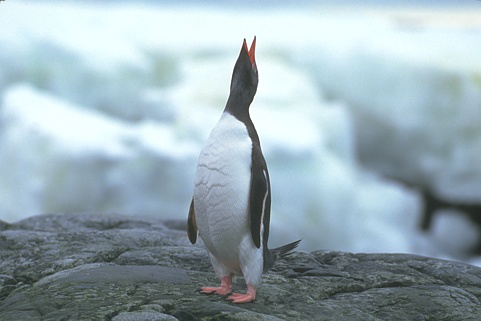

In [4]:
PIL.Image.open(str(test_temp[0]))

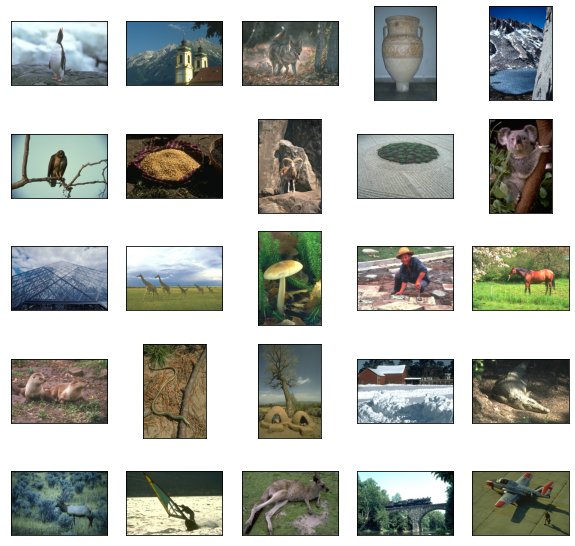

In [5]:
#codice per mostrare alcuni esempi
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PIL.Image.open(str(test_temp[i])), cmap=plt.cm.binary)
   
plt.show()

Codice per caricare immagini in array di pixel e ruotare

In [20]:
test=[]
for i in range(image_count_test):
  image=PIL.Image.open(str(test_temp[i]))
  if(image.height > image.width):
    image=image.transpose(PIL.Image.ROTATE_90)
  test.append(image)
  
train=[]
for i in range(image_count_train):
  image=PIL.Image.open(str(train_temp[i]))
  if(image.height > image.width):
    image=image.transpose(PIL.Image.ROTATE_90)
  train.append(image)

image_size=[image.width, image.height]
print(image_size)

[481, 321]


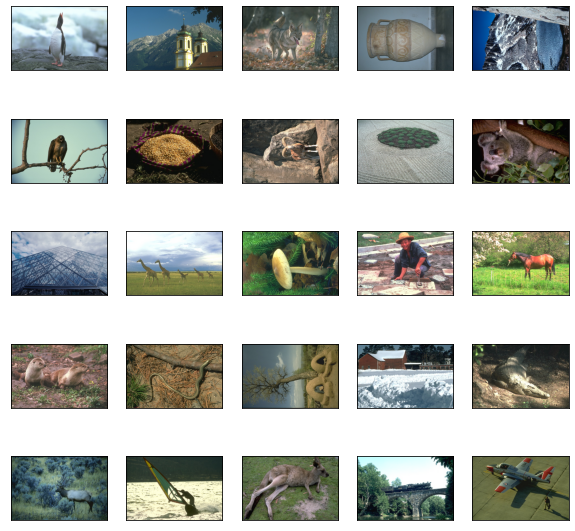

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
   
plt.show()

In [13]:
print(image_size)

[481, 321]


## Adding Noise

In [ ]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

In [ ]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.005, 0.03
    sigma = 0.005
    var=truncnorm_(lower, upper, sigma)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.02, 0.07
    sigma = 0.01

    amount=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.005, 0.02
    sigma = 0.003

    var=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('PANIC: Wrong noise index.')
    return

  return 255*noise_img #random_noise returns [0,1] or [-1,1] value

In [ ]:
from matplotlib import pyplot as plt

for i in range(5):
    plt.figure(figsize=(50,45), dpi=80)

    img = cv2.imread(str(test_temp[i]))
    noise_img=apply_noise_to_image(img)
    noise_img=np.array(noise_img, dtype = 'uint8')
    noise_img_rgb=cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)

    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((noise_img_rgb), cmap=plt.cm.binary)
   
plt.show()

## Generatore - Discriminatore 

In [ ]:
def build_generator(width, height, inputDim=100, n1=512, channels=3):

  inp = Input(shape=(inputDim,))
  # RIMPICCIOLISCE
  # FC - BN 
  dim1 = width // 16     # because we have 4 transpose conv layers with strides 2 -> 
                        # -> we are upsampling by a factor of 16
  dim2 = height // 16
  
  x = Dense( dim1 * dim2 * n1, activation="relu")(inp)
  x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  # Reshape to width * heigh * feature_channels

  x = Reshape((dim1, dim2,n1))(x)

  # alternative formulation: batchnorm before activation
  #x = Conv2DTranspose(n1//2, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  #x = Conv2DTranspose(n1//4, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)
  #x = Conv2DTranspose(n1//8, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

 
  # AUMENTA DIMENSIONE
  # now add conv 2D transpose
  x = Conv2DTranspose(n1//2, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(n1//4, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(n1//8, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  
  # now add final layer with tanh activation
  out = Conv2DTranspose(channels, (5,5), strides=(2,2), padding="same", activation="tanh")(x)

  m = Model(inputs=inp, outputs=out)
  return m

In [35]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	#g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [44]:
image_shape=image_size
print(image_size)

[481, 321]


In [58]:
from numpy.core.fromnumeric import resize
def define_generator(image_shape):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  #g=Reshape(image_shape)(g)
  #############################################################################
  # TO DO
  #g=resize(g, image_shape)
  
  #############################################################################
  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image)
  return model

In [59]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_shape)
	# target image input
	# concatenate images channel-wise
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [60]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model


In [61]:
dataset = train
print('Loaded', image.width, image.height)
# define input shape based on the loaded dataset
image_shape = [image.width, image.height, 3]
print(image_shape[0:2])
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

Loaded 481 321
[481, 321]


TypeError: ignored

In [41]:
d_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 481, 321, 3)]     0         
                                                                 
 conv2d_98 (Conv2D)          (None, 241, 161, 64)      3136      
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 241, 161, 64)      0         
                                                                 
 conv2d_99 (Conv2D)          (None, 121, 81, 128)      131200    
                                                                 
 batch_normalization_80 (Bat  (None, 121, 81, 128)     512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 121, 81, 128)      0         
                                                           

In [53]:
g_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 481, 321, 3)]     0         
                                                                 
 conv2d_104 (Conv2D)         (None, 241, 161, 64)      3136      
                                                                 
 leaky_re_lu_87 (LeakyReLU)  (None, 241, 161, 64)      0         
                                                                 
 conv2d_105 (Conv2D)         (None, 121, 81, 128)      131200    
                                                                 
 batch_normalization_84 (Bat  (None, 121, 81, 128)     512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_88 (LeakyReLU)  (None, 121, 81, 128)      0         
                                                          

In [40]:
gan_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 481, 321, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_10 (Functional)          (None, 512, 512, 3)  39090819    ['input_26[0][0]']               
                                                                                                  
 model_9 (Functional)           (None, 31, 21, 1)    6965185     ['input_26[0][0]',               
                                                                  'model_10[0][0]']               
                                                                                           

In [ ]:
def build_discriminator(width, height, channels, alpha=0.2, droprate=0.4):
    input_shape = (width, height, channels)

    # use Leaky ReLU instead of Relu in the discriminator
    leaky = tf.keras.layers.LeakyReLU(alpha)
    n1 = 128
    n2 = 256
    n3 = 512

    inp = Input(shape=input_shape)
    x = Conv2D(n1, (5,5), strides=(2,2), activation=leaky)(inp)
    #x = MaxPooling2D(strides=2)(x)
    x = Conv2D(n2, (5,5), strides=(2,2), activation=leaky)(x)
    #x = MaxPooling2D(strides=2)(x)
    x = Conv2D(n3, (3,3), strides=(2,2), activation=leaky)(x)
   # x = MaxPooling2D(strides=2)(x)
   
    x = Flatten()(x)
   # x = Dense(n3/8, activation=leaky)(x)

    #use dropout to increase variability in the discriminator
    x = Dropout(droprate)(x)
    out = Dense(1, activation="sigmoid")(x)

    m = Model(inputs=inp, outputs=out)
    return m